# CASO PRÁCTICO 1

## Apartado a)

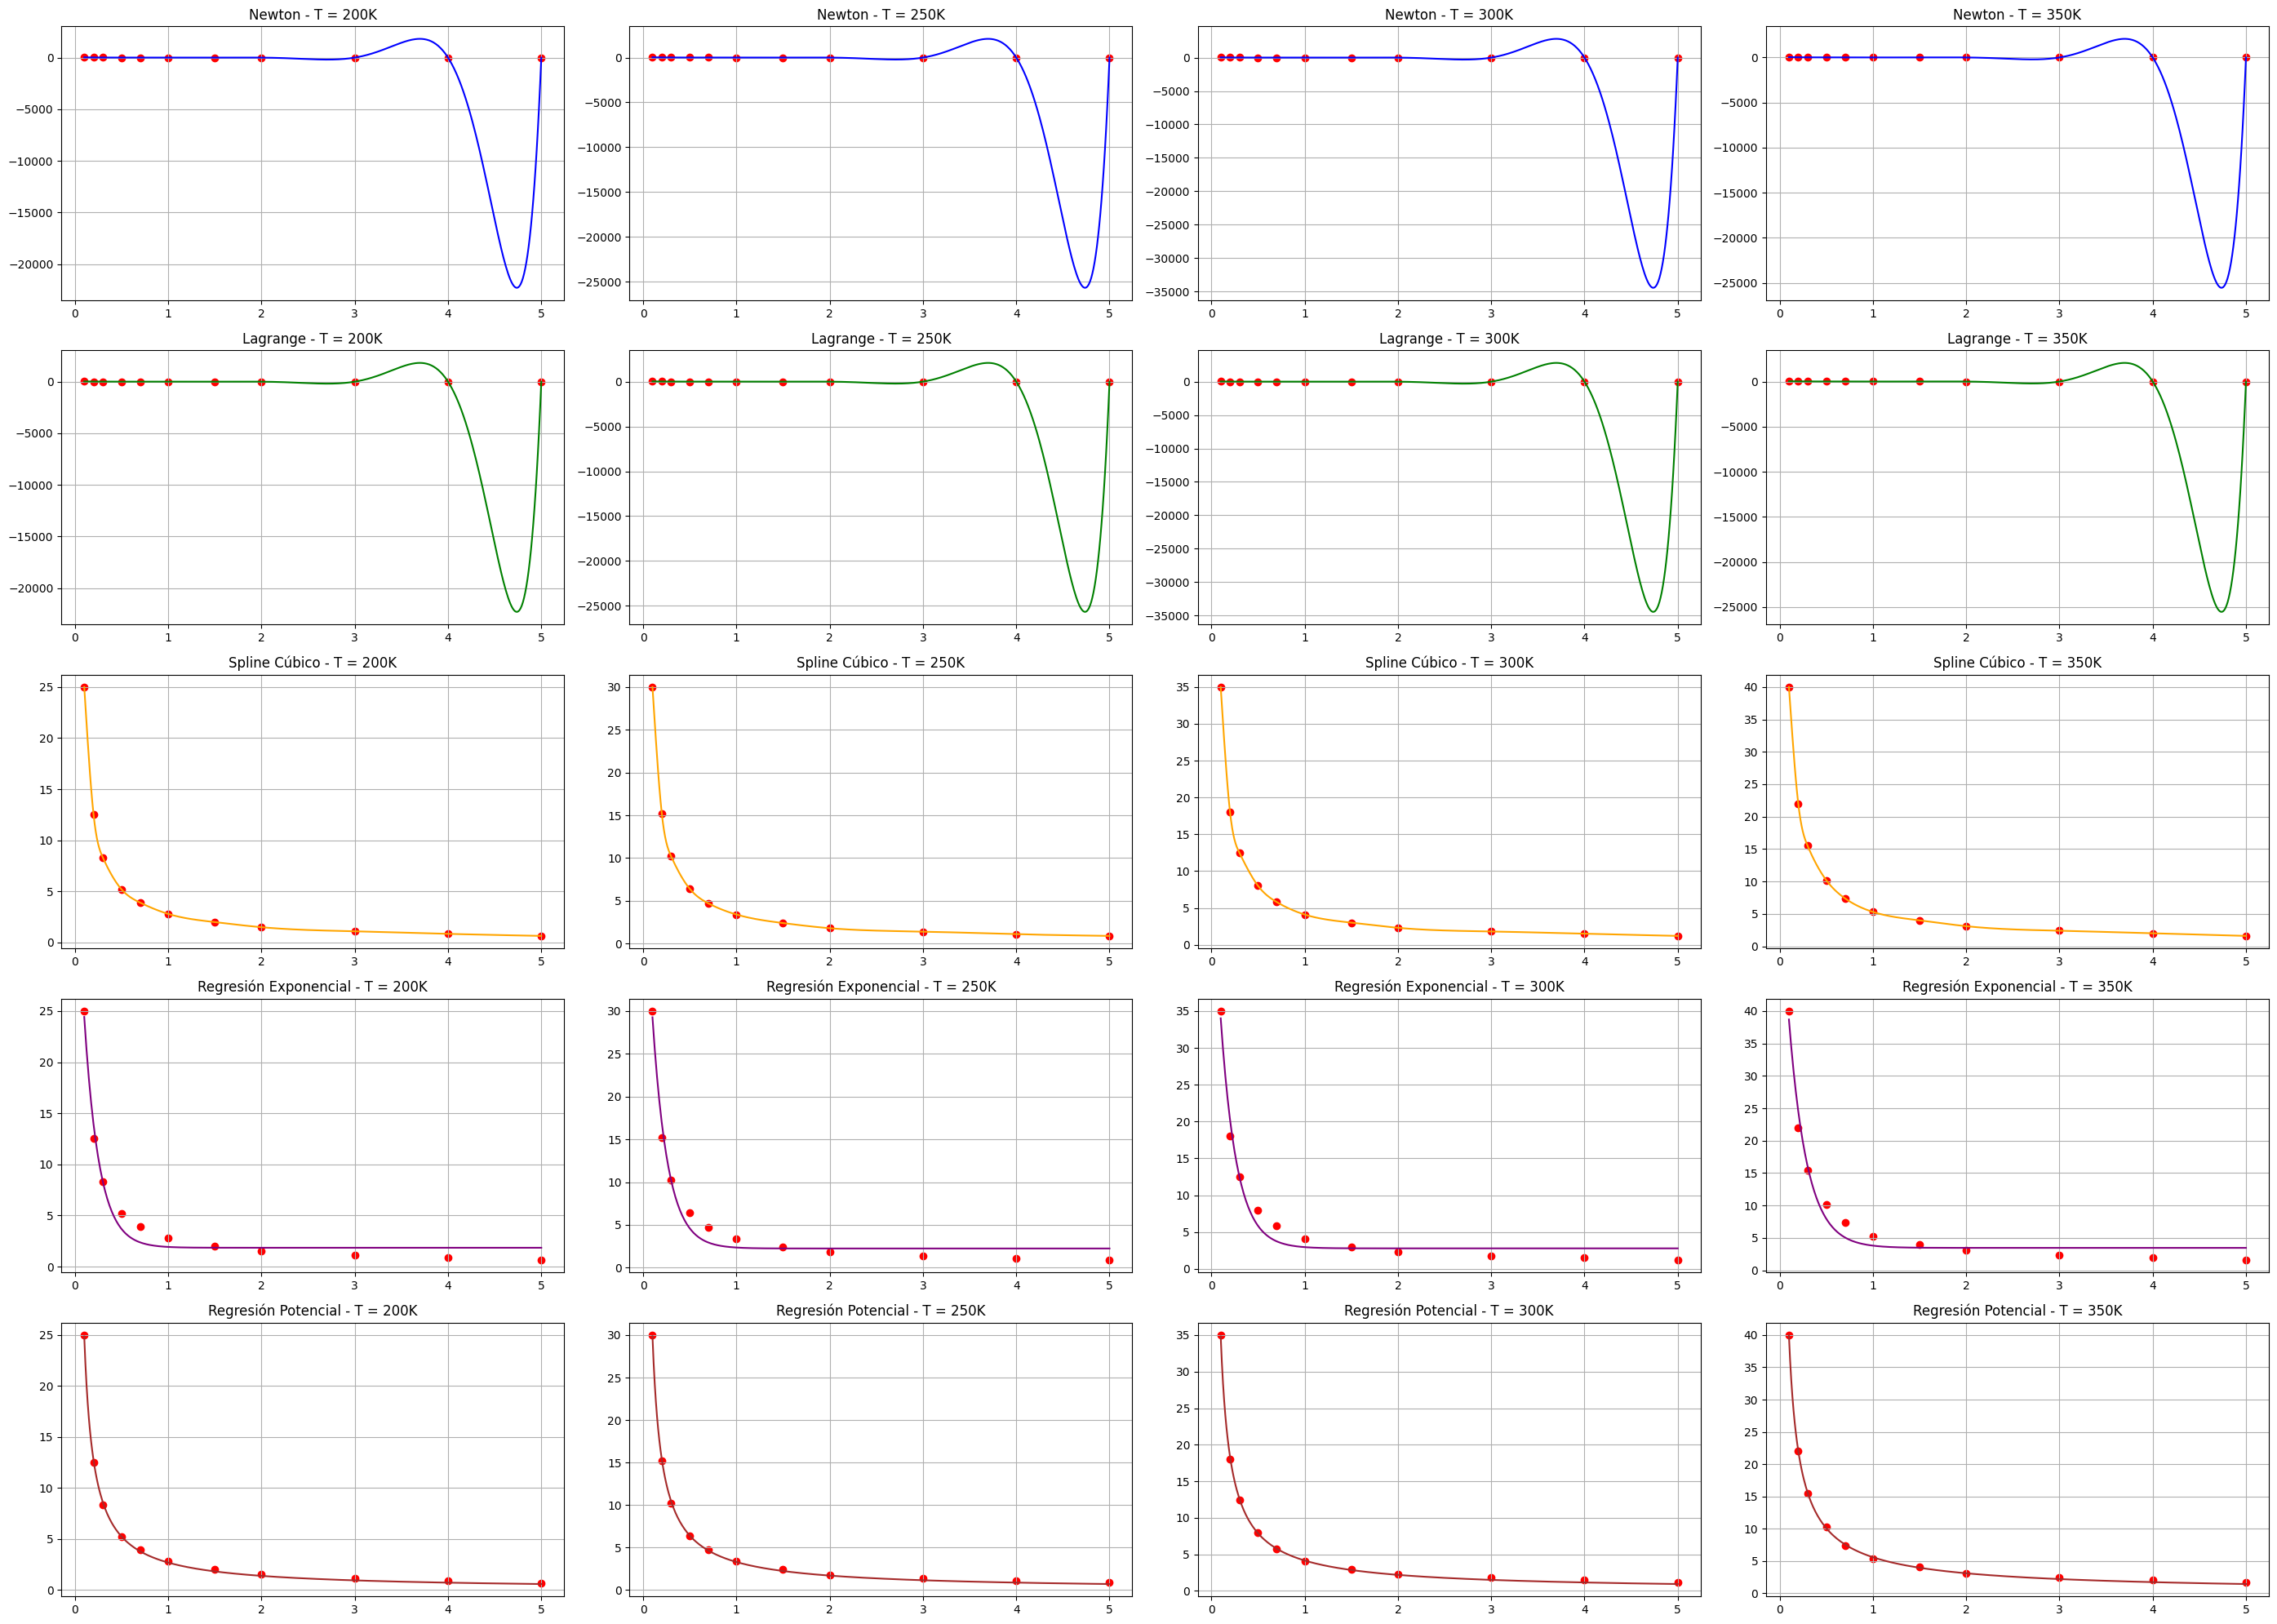


Tabla de SSE (Suma de Errores Cuadrados):
            Newton      Lagrange        Spline  Exponencial  Potencial
200K  1.551924e-13  4.268545e-12  1.232595e-32    10.832177   0.289259
250K  4.694071e-14  7.273818e-13  1.232595e-32    15.000467   0.308401
300K  6.870000e-12  3.547599e-11  0.000000e+00    21.673696   0.501166
350K  1.162749e-15  3.990856e-14  0.000000e+00    28.180216   0.312619

Mejor modelo por temperatura:
200K    Spline
250K    Spline
300K    Spline
350K    Spline


In [20]:
# Importar bibliotecas necesarias
import numpy as np
from sympy import symbols, simplify, lambdify, prod
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import pandas as pd

# ------------------- FUNCIONES DE INTERPOLACIÓN ---------------------

# Calcula la tabla de diferencias divididas para el método de Newton
def diferencias_divididas(x, y):
    n = len(y)
    coef = np.zeros([n, n])
    coef[:, 0] = y
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])
    return coef

# Construye el polinomio simplificado de Newton usando sympy
def construir_polinomio_simplificado(coef, x):
    x_sym = symbols('x')
    n = len(coef[0])
    polinomio = coef[0, 0]
    terminos = 1
    polinomio_expr = polinomio
    for i in range(1, n):
        terminos *= (x_sym - x[i-1])
        polinomio_expr += coef[0, i] * terminos
    return simplify(polinomio_expr)

# Construye el polinomio de interpolación de Lagrange
def lagrange_interpolation(x, y):
    x_sym = symbols('x')
    n = len(x)
    polinomio = 0
    for i in range(n):
        L_i = prod((x_sym - x[j]) / (x[i] - x[j]) for j in range(n) if j != i)
        polinomio += y[i] * L_i
    return simplify(polinomio)

# --------------------- MODELOS DE REGRESIÓN ------------------------

# Modelo de regresión exponencial ajustable
def modelo_exponencial(x, a, b, c, d):
    return a * np.exp(-b * x / d) + c

# Modelo de regresión potencial
def modelo_potencial(P, a, b):
    return a * P**b

# ---------------------------- DATOS -------------------------------

# Diccionario con datos de presión (P) y volumen específico (V) para varias temperaturas
datos = {
    "200K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [25.0, 12.5, 8.3, 5.2, 3.9, 2.8, 2.0, 1.5, 1.1, 0.85, 0.65]
    },
    "250K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9]
    },
    "300K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [35.0, 18.0, 12.5, 8.0, 5.8, 4.1, 3.0, 2.3, 1.8, 1.5, 1.2]
    },
    "350K": {
        "P": [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0],
        "V": [40.0, 22.0, 15.5, 10.2, 7.4, 5.3, 4.0, 3.1, 2.4, 2.0, 1.6]
    }
}

# ------------------ PROCESAMIENTO Y GRÁFICAS -----------------------

sse_resultados = {}  # Diccionario para almacenar errores SSE
fig, axes = plt.subplots(5, 4, figsize=(28, 20))  # Subplots 5 filas × 4 columnas
x_sym = symbols('x')

for idx, (T, valores) in enumerate(datos.items()):
    x = np.array(valores["P"])
    y = np.array(valores["V"])
    x_vals = np.linspace(x.min(), x.max(), 400)

    errores = {}

    # ---- NEWTON ----
    coef = diferencias_divididas(x, y)
    poly_newton = construir_polinomio_simplificado(coef, x)
    f_newton = lambdify(x_sym, poly_newton, 'numpy')
    y_newton = f_newton(x)
    errores["Newton"] = np.sum((y - y_newton)**2)
    ax = axes[0, idx]
    ax.plot(x_vals, f_newton(x_vals), color="blue")
    ax.scatter(x, y, color="red")
    ax.set_title(f"Newton - T = {T}")
    ax.grid(True)

    # ---- LAGRANGE ----
    poly_lagrange = lagrange_interpolation(x, y)
    f_lagrange = lambdify(x_sym, poly_lagrange, 'numpy')
    y_lagrange = f_lagrange(x)
    errores["Lagrange"] = np.sum((y - y_lagrange)**2)
    ax = axes[1, idx]
    ax.plot(x_vals, f_lagrange(x_vals), color="green")
    ax.scatter(x, y, color="red")
    ax.set_title(f"Lagrange - T = {T}")
    ax.grid(True)

    # ---- SPLINE CÚBICO ----
    cs = CubicSpline(x, y, bc_type='natural')
    y_spline = cs(x)
    errores["Spline"] = np.sum((y - y_spline)**2)
    ax = axes[2, idx]
    ax.plot(x_vals, cs(x_vals), color="orange")
    ax.scatter(x, y, color="red")
    ax.set_title(f"Spline Cúbico - T = {T}")
    ax.grid(True)

    # ---- REGRESIÓN EXPONENCIAL ----
    try:
        params_exp, _ = curve_fit(modelo_exponencial, x, y, p0=[max(y), 1, min(y), 1])
        y_exp = modelo_exponencial(x, *params_exp)
        errores["Exponencial"] = np.sum((y - y_exp)**2)
        ax = axes[3, idx]
        ax.plot(x_vals, modelo_exponencial(x_vals, *params_exp), color="purple")
        ax.scatter(x, y, color="red")
        ax.set_title(f"Regresión Exponencial - T = {T}")
        ax.grid(True)
    except RuntimeError:
        errores["Exponencial"] = np.nan
        axes[3, idx].text(0.5, 0.5, 'Ajuste fallido', ha='center', va='center')

    # ---- REGRESIÓN POTENCIAL ----
    try:
        params_pot, _ = curve_fit(modelo_potencial, x, y, p0=[1, -1])
        y_pot = modelo_potencial(x, *params_pot)
        errores["Potencial"] = np.sum((y - y_pot)**2)
        ax = axes[4, idx]
        ax.plot(x_vals, modelo_potencial(x_vals, *params_pot), color="brown")
        ax.scatter(x, y, color="red")
        ax.set_title(f"Regresión Potencial - T = {T}")
        ax.grid(True)
    except RuntimeError:
        errores["Potencial"] = np.nan
        axes[4, idx].text(0.5, 0.5, 'Ajuste fallido', ha='center', va='center')

    sse_resultados[T] = errores  # Guardar errores de esta temperatura

# Ajustar diseño de la figura
plt.tight_layout()
plt.show()

# ---------------------- ANÁLISIS FINAL -----------------------

# Mostrar tabla de errores SSE por método y temperatura
df_sse = pd.DataFrame(sse_resultados).T
print("\nTabla de SSE (Suma de Errores Cuadrados):")
print(df_sse)

# Mostrar el mejor modelo (con menor error) por temperatura
print("\nMejor modelo por temperatura:")
print(df_sse.idxmin(axis=1).to_string())


## Apartado b)

Tabla de Diferencias Divididas para Hermite:
     0      1        2             3             4
0  2.8  0.012  0.00002  8.000000e-07 -5.333333e-09
1  3.4  0.014  0.00010  0.000000e+00  0.000000e+00
2  4.1  0.019  0.00010  0.000000e+00  0.000000e+00
3  4.1  0.024  0.00000  0.000000e+00  0.000000e+00
4  5.3  0.000  0.00000  0.000000e+00  0.000000e+00

Polinomio de Interpolación de Hermite:
H(T) = 2.8000 + 1.2e-2·(T - 200) + 2.0e-5·(T - 200)·(T - 250) + 8.0e-7·(T - 200)·(T - 250)·(T - 300) - 5.3e-9·(T - 200)·(T - 250)·(T - 300)·(T - 300)


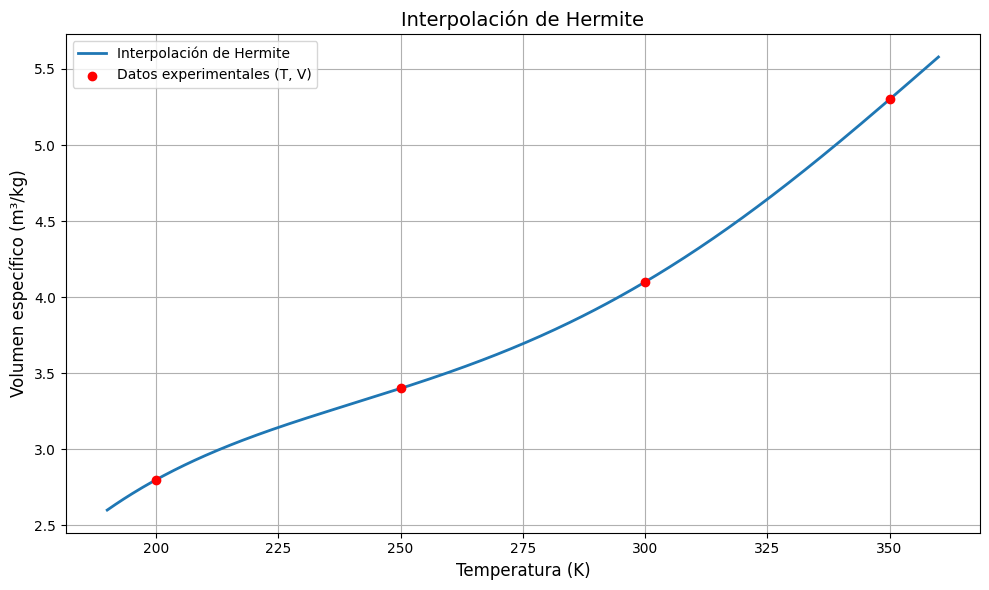

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import symbols, lambdify, N

# Función que construye la tabla de diferencias divididas de Hermite
def diferencias_divididas_hermite(data_points, derivatives_info):
    n = len(data_points)  # Número de puntos de datos originales
    z = []                # Lista de nodos (se repiten si hay derivadas)
    Q = []                # Tabla de diferencias divididas

    # Insertar cada punto (y su derivada, si está disponible)
    for i, (T_i, v_i) in enumerate(data_points):
        z.append(T_i)         # Añadir nodo
        Q.append([v_i])       # Añadir valor f(x)

        if T_i in derivatives_info:  # Si se conoce la derivada en ese punto
            z.append(T_i)            # Repetir el nodo
            Q.append([v_i])          # Repetir el valor f(x)
            # Añadir f'(x) como primera diferencia dividida
            Q[-1].append(derivatives_info[T_i])
            Q[-2].append((Q[-2][0] - Q[-3][0]) / (z[-2] - z[-3]) if len(Q) > 2 else derivatives_info[T_i])

    m = len(z)  # Total de nodos en z (ya duplicados si hay derivadas)

    # Completar las filas de Q con ceros hasta tener m columnas
    for row in Q:
        while len(row) < m:
            row.append(0)

    # Calcular diferencias divididas de orden superior
    for j in range(1, m):
        for i in range(m - j):
            # Si hay nodo repetido, usar directamente la derivada
            if j == 1 and z[i] == z[i + 1]:
                Q[i][j] = Q[i + 1][1]
            else:
                # Fórmula de diferencias divididas
                Q[i][j] = (Q[i + 1][j - 1] - Q[i][j - 1]) / (z[i + j] - z[i])

    return z, np.array(Q)  # Retornar nodos y la tabla como array de numpy

# Función que imprime el polinomio de Hermite en formato legible
def imprimir_polinomio_formato_hermite(coef, z):
    T = symbols('T')
    n = len(coef[0])  # Número de términos del polinomio
    expresion = f"H(T) = {coef[0, 0]:.4f}"  # Primer término (constante)
    producto = ""  # Inicializar parte multiplicativa del polinomio

    for i in range(1, n):
        producto += f"·(T - {z[i - 1]})"
        valor = N(coef[0, i], 4)  # Convertir a número con 4 cifras significativas
        if valor != 0:
            if valor > 0:
                expresion += f" + {valor:.1e}{producto}"
            else:
                expresion += f" - {abs(valor):.1e}{producto}"

    print(expresion)  # Mostrar resultado

# ----------------------------- EJECUCIÓN DEL CÓDIGO -----------------------------

# Datos experimentales (temperatura, volumen específico)
data_points = [(200, 2.8), (250, 3.4), (300, 4.1), (350, 5.3)]

# Información adicional: derivada conocida en T = 300
derivatives_info = {300: 0.019}

# Calcular tabla de Hermite
z, tabla_coef_hermite = diferencias_divididas_hermite(data_points, derivatives_info)

# Convertir a DataFrame para visualizar mejor
tabla_df_hermite = pd.DataFrame(tabla_coef_hermite).fillna('')

# Mostrar tabla por consola
print("Tabla de Diferencias Divididas para Hermite:")
print(tabla_df_hermite)

# Mostrar polinomio de Hermite no simplificado
print("\nPolinomio de Interpolación de Hermite:")
imprimir_polinomio_formato_hermite(tabla_coef_hermite, z)

# Definir la variable simbólica T
T = symbols('T')

# Construir el polinomio de Hermite como función evaluable con numpy
hermite_func = lambdify(T, sum(
    tabla_coef_hermite[0, i] * np.prod([(T - z[k]) for k in range(i)])
    for i in range(len(z))
), 'numpy')

# Valores para graficar el polinomio
x_vals = np.linspace(190, 360, 400)  # Rango de T
y_vals = hermite_func(x_vals)       # Evaluar polinomio

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Interpolación de Hermite', linewidth=2)
plt.scatter(*zip(*data_points), color='red', label='Datos experimentales (T, V)', zorder=5)
plt.title('Interpolación de Hermite', fontsize=14)
plt.xlabel('Temperatura (K)', fontsize=12)
plt.ylabel('Volumen específico (m³/kg)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


## Apartado c)

### Curva Regresión Exponencial

Presión (MPa) | V_exp (m³/mol) | V_PR (m³/mol) | Error absoluto
         0.10 |        0.48120 |       0.02070 |        0.46050
         0.20 |        0.24381 |       0.01031 |        0.23350
         0.30 |        0.16361 |       0.00685 |        0.15676
         0.50 |        0.10266 |       0.00408 |        0.09858
         0.70 |        0.07539 |       0.00289 |        0.07250
         1.00 |        0.05454 |       0.00200 |        0.05254
         1.50 |        0.03850 |       0.00131 |        0.03719
         2.00 |        0.02887 |       0.00096 |        0.02791
         3.00 |        0.02246 |       0.00061 |        0.02184
         4.00 |        0.01764 |       0.00044 |        0.01720
         5.00 |        0.01444 |       0.00034 |        0.01410

Error absoluto máximo: 0.46050 m³/mol
Error absoluto promedio: 0.10842 m³/mol


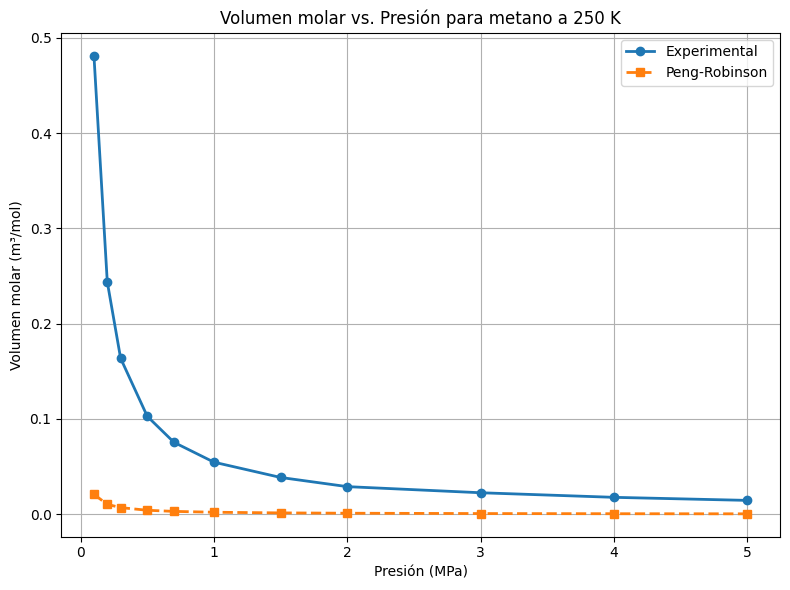

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Constantes
R = 8.314  # J/(mol·K)
Tc = 190.56  # K
Pc = 4.59e6  # Pa
omega = 0.011
M_metan = 16.04  # g/mol -> kg/mol
T = 250  # K

# Datos experimentales
P_exp = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]) * 1e6  # Pa
V_exp_m3_kg = np.array([30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9])  # m³/kg
V_exp_m3_mol = V_exp_m3_kg * (M_metan / 1000)  # m³/mol

# Cálculo de parámetros
Tr = T / Tc
k = 0.37 + 1.5 * omega - 0.26 * omega ** 2
alpha = (1 + k * (1 - np.sqrt(Tr))) ** 2
a = 0.45724 * R**2 * Tc**2 / Pc * alpha
b = 0.07780 * R * Tc / Pc

# Ecuación de Peng-Robinson
def peng_robinson_eq(V, P, T):
    term1 = R * T / (V - b)
    term2 = a / (V**2 + 2*b*V - b**2)
    return term1 - term2 - P

# Resolver para cada P experimental
V_pr = []
for P in P_exp:
    V_guess = R * T / P
    V_solution, = fsolve(peng_robinson_eq, V_guess, args=(P, T), xtol=0.001)
    V_pr.append(V_solution)

V_pr = np.array(V_pr)

# Errores
errores = np.abs(V_exp_m3_mol - V_pr)
errores_max = errores.max()
errores_prom = errores.mean()

# Mostrar resultados
print("Presión (MPa) | V_exp (m³/mol) | V_PR (m³/mol) | Error absoluto")
for p, v_exp, v_calc, err in zip(P_exp/1e6, V_exp_m3_mol, V_pr, errores):
    print(f"{p:13.2f} | {v_exp:14.5f} | {v_calc:13.5f} | {err:14.5f}")

print(f"\nError absoluto máximo: {errores_max:.5f} m³/mol")
print(f"Error absoluto promedio: {errores_prom:.5f} m³/mol")

# Gráfica
plt.figure(figsize=(8, 6))
plt.plot(P_exp / 1e6, V_exp_m3_mol, 'o-', label='Experimental', linewidth=2)
plt.plot(P_exp / 1e6, V_pr, 's--', label='Peng-Robinson', linewidth=2)
plt.xlabel('Presión (MPa)')
plt.ylabel('Volumen molar (m³/mol)')
plt.title('Volumen molar vs. Presión para metano a 250 K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Curva Spline Cúbico

    P (MPa)  V spline (m³/mol)  V PR (m³/mol)  Error absoluto (m³/mol)
0       0.1           0.481200       0.020705                 0.460495
1       0.2           0.243808       0.010312                 0.233496
2       0.3           0.163608       0.006848                 0.156760
3       0.5           0.102656       0.004077                 0.098579
4       0.7           0.075388       0.002889                 0.072499
5       1.0           0.054536       0.001998                 0.052538
6       1.5           0.038496       0.001305                 0.037191
7       2.0           0.028872       0.000959                 0.027913
8       3.0           0.022456       0.000613                 0.021843
9       4.0           0.017644       0.000440                 0.017204
10      5.0           0.014436       0.000337                 0.014099

Error absoluto máximo: 0.460495 m³/mol
Error absoluto medio: 0.108420 m³/mol


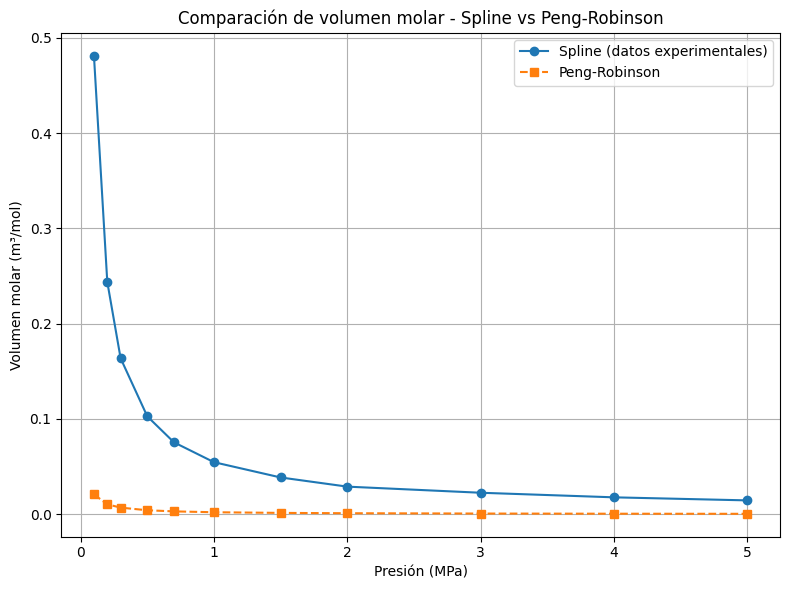

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
import pandas as pd

# Constantes
R = 8.314  # J/(mol·K)
Tc = 190.56  # K
Pc = 4.59e6  # Pa
w = 0.011
T = 250  # K
M_metano = 0.01604  # kg/mol

# Datos para T = 250 K
P_MPa = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0])  # MPa
P = P_MPa * 1e6  # Convertir a Pa
V_esp_m3kg = np.array([30.0, 15.2, 10.2, 6.4, 4.7, 3.4, 2.4, 1.8, 1.4, 1.1, 0.9])  # m³/kg
V = V_esp_m3kg * M_metano  # m³/mol

# Crear spline cúbico
cs = CubicSpline(P, V, bc_type='natural')

# Parámetros de la ecuación de Peng-Robinson
Tr = T / Tc
k = 0.37 + 1.5 * w - 0.26 * w**2
alpha = (1 + k * (1 - np.sqrt(T / Tc)))**2
a = 0.45724 * (R**2 * Tc**2 / Pc) * alpha
b = 0.07780 * R * Tc / Pc

# Función de Peng-Robinson
def PR_eq(V, P):
    return R * T / (V - b) - a / (V**2 + 2 * b * V - b**2) - P

# Resolver para cada P usando fsolve
V_sol = []
errors = []

for p_i in P:
    V_init = cs(p_i)  # Valor inicial desde spline
    V_pr = fsolve(PR_eq, V_init, args=(p_i))[0]
    V_spline = cs(p_i)
    error = abs(V_pr - V_spline)
    V_sol.append(V_pr)
    errors.append(error)

# Crear DataFrame con resultados
df = pd.DataFrame({
    "P (MPa)": P_MPa,
    "V spline (m³/mol)": cs(P),
    "V PR (m³/mol)": V_sol,
    "Error absoluto (m³/mol)": errors
})
print(df)

# Calcular errores resumen
mean_error = np.mean(errors)
max_error = np.max(errors)

print(f"\nError absoluto máximo: {max_error:.6f} m³/mol")
print(f"Error absoluto medio: {mean_error:.6f} m³/mol")

# Graficar resultados
plt.figure(figsize=(8, 6))
plt.plot(P_MPa, cs(P), 'o-', label='Spline (datos experimentales)')
plt.plot(P_MPa, V_sol, 's--', label='Peng-Robinson')
plt.xlabel('Presión (MPa)')
plt.ylabel('Volumen molar (m³/mol)')
plt.title('Comparación de volumen molar - Spline vs Peng-Robinson')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Diagrama de Flujo

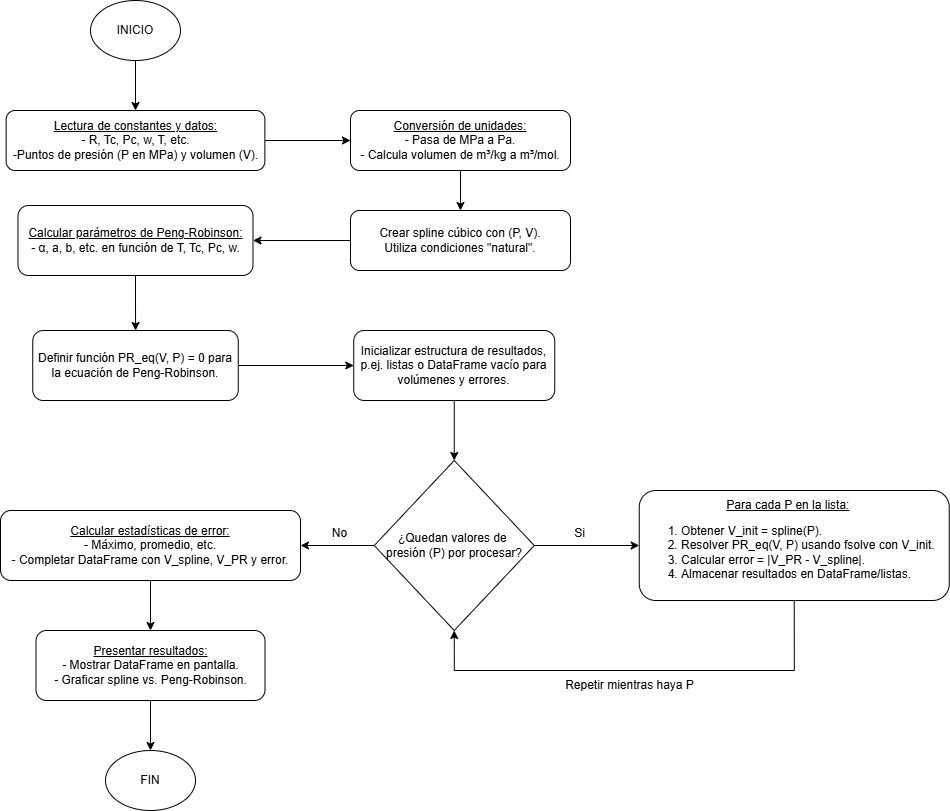

In [3]:
from IPython.display import Image

# Mostrar imagen directamente en el notebook
Image("Diagrama_de_Flujo.jpg")

## Apartado d)

Tolerancia  Iteraciones  Temperatura encontrada (K)
      0.01           15                  134.530118
     0.001           16                  134.529259
1.0·10^⁻10           19                  134.529241


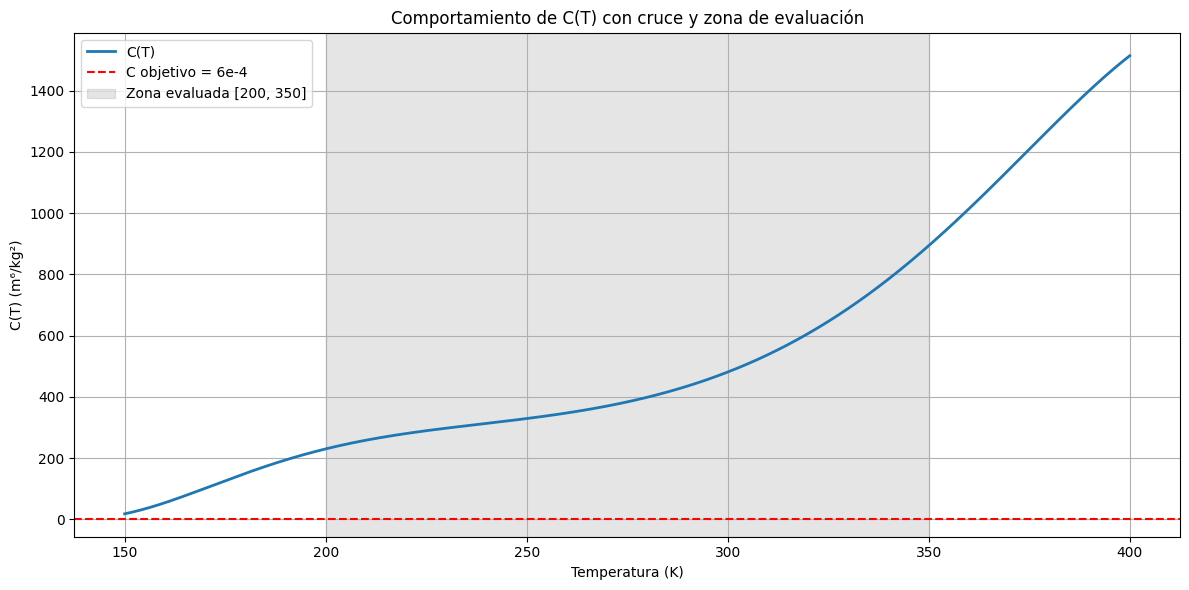

In [4]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import symbols, lambdify

# ------------------ DATOS ------------------

# Datos experimentales (temperatura, volumen específico)
data_points = [(200, 2.8), (250, 3.4), (300, 4.1), (350, 5.3)]
derivatives_info = {300: 0.019}

# Constantes del problema
P = 1e6  # Presión en Pa (1 MPa)
R = 461.5  # Constante del gas específico en J/(kg·K)
C_target = 6e-4  # Valor objetivo del coeficiente del virial (m^6/kg^2)

# ------------------ HERMITE ------------------

def diferencias_divididas_hermite(data_points, derivatives_info):
    z = []
    Q = []

    for T_i, v_i in data_points:
        z.append(T_i)
        Q.append([v_i])
        if T_i in derivatives_info:
            z.append(T_i)
            Q.append([v_i])
            Q[-1].append(derivatives_info[T_i])
            Q[-2].append(derivatives_info[T_i])

    m = len(z)
    for row in Q:
        while len(row) < m:
            row.append(0)

    for j in range(1, m):
        for i in range(m - j):
            if j == 1 and z[i] == z[i + 1]:
                Q[i][j] = Q[i + 1][1]
            else:
                Q[i][j] = (Q[i + 1][j - 1] - Q[i][j - 1]) / (z[i + j] - z[i])

    return z, np.array(Q)

z, tabla_coef_hermite = diferencias_divididas_hermite(data_points, derivatives_info)

# Construir polinomio de Hermite
T = symbols('T')
hermite_expr = sum(
    tabla_coef_hermite[0, i] * np.prod([(T - z[k]) for k in range(i)])
    for i in range(len(z))
)
hermite_func = lambdify(T, hermite_expr, 'numpy')

# ------------------ FUNCIONES ------------------

# Coeficiente B(T)
B = lambda T_val: -0.199 + 0.20 * np.exp(-1131 / T_val**2)

# Función C(T)
def C_T(T_val):
    v_val = hermite_func(T_val)
    Z = P * v_val / (R * T_val)
    return v_val**2 * (Z - 1 - B(T_val)/v_val)

# Método de la secante
def secante(func, x0, x1, tol, max_iter=1000):
    iteraciones = 0
    while abs(x1 - x0) > tol and iteraciones < max_iter:
        f_x0 = func(x0)
        f_x1 = func(x1)
        if f_x1 - f_x0 == 0:
            break
        x_temp = x1 - f_x1 * (x1 - x0) / (f_x1 - f_x0)
        x0, x1 = x1, x_temp
        iteraciones += 1
    return x1, iteraciones

# ------------------ EJECUCIÓN ------------------

# Tolerancias a evaluar
tolerancias = [0.01, 0.001, 1e-10]
resultados_secante = []

for tol in tolerancias:
    T_encontrada, n_iter = secante(lambda T_val: C_T(T_val) - C_target, 200, 350, tol)
    resultados_secante.append((tol, n_iter, T_encontrada))

# Crear DataFrame
df_resultados = pd.DataFrame(resultados_secante, columns=["Tolerancia", "Iteraciones", "Temperatura encontrada (K)"])

# Redondear temperatura a 6 decimales
df_resultados["Temperatura encontrada (K)"] = df_resultados["Temperatura encontrada (K)"].round(6)

# Formatear tolerancia con representación científica solo para valores pequeños
def formatear_tolerancia(x):
    if x >= 1e-3:
        return f"{x:.3f}".rstrip('0').rstrip('.')  # Quita ceros y puntos sobrantes
    else:
        return f"{x:.1e}".replace('e-0', '·10^⁻').replace('e-', '·10^⁻')

df_resultados["Tolerancia"] = df_resultados["Tolerancia"].apply(formatear_tolerancia)

# Mostrar tabla
print(df_resultados.to_string(index=False))

# ------------------ GRÁFICA ------------------

# Ampliar el rango de temperaturas para ver mejor el comportamiento global
T_vals_plot = np.linspace(150, 400, 1000)
C_vals = [C_T(T_val) for T_val in T_vals_plot]

# Encontrar intersección con el objetivo (si existe dentro del rango)
intersecciones = []
for i in range(len(T_vals_plot) - 1):
    if (C_vals[i] - C_target) * (C_vals[i + 1] - C_target) < 0:
        T0, T1 = T_vals_plot[i], T_vals_plot[i + 1]
        T_intersect, _ = secante(lambda T: C_T(T) - C_target, T0, T1, 1e-10)
        intersecciones.append(T_intersect)

plt.figure(figsize=(12, 6))
plt.plot(T_vals_plot, C_vals, label='C(T)', linewidth=2)

# Línea horizontal del objetivo
plt.axhline(C_target, color='red', linestyle='--', label='C objetivo = 6e-4')

# Marcar intersecciones
for T_cross in intersecciones:
    plt.axvline(T_cross, color='green', linestyle=':', label=f'Cruce: T ≈ {T_cross:.2f} K')

# Rellenar zona entre 200 y 350 K
plt.axvspan(200, 350, color='gray', alpha=0.2, label='Zona evaluada [200, 350]')

plt.xlabel('Temperatura (K)')
plt.ylabel('C(T) (m⁶/kg²)')
plt.title('Comportamiento de C(T) con cruce y zona de evaluación')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Apartado e)

C objetivo (m^6/kg^2) Tolerancia  Iteraciones  Temperatura encontrada (K)
            1.0·10^⁻4      0.001           18                  134.401778
            8.5·10^⁻4      0.001           16                  134.572300


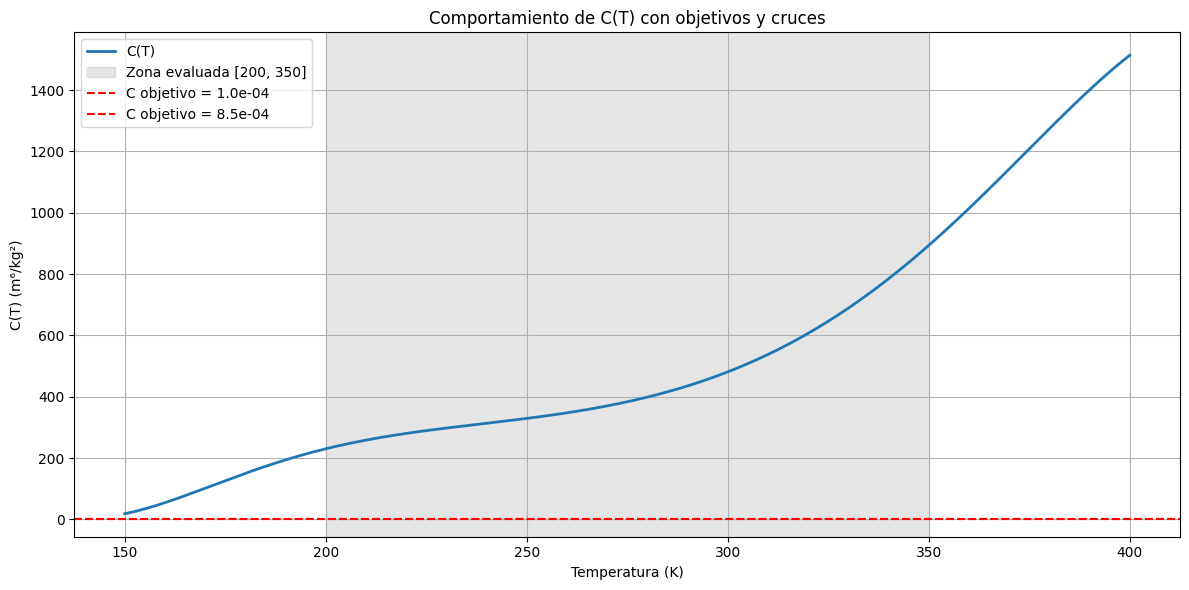

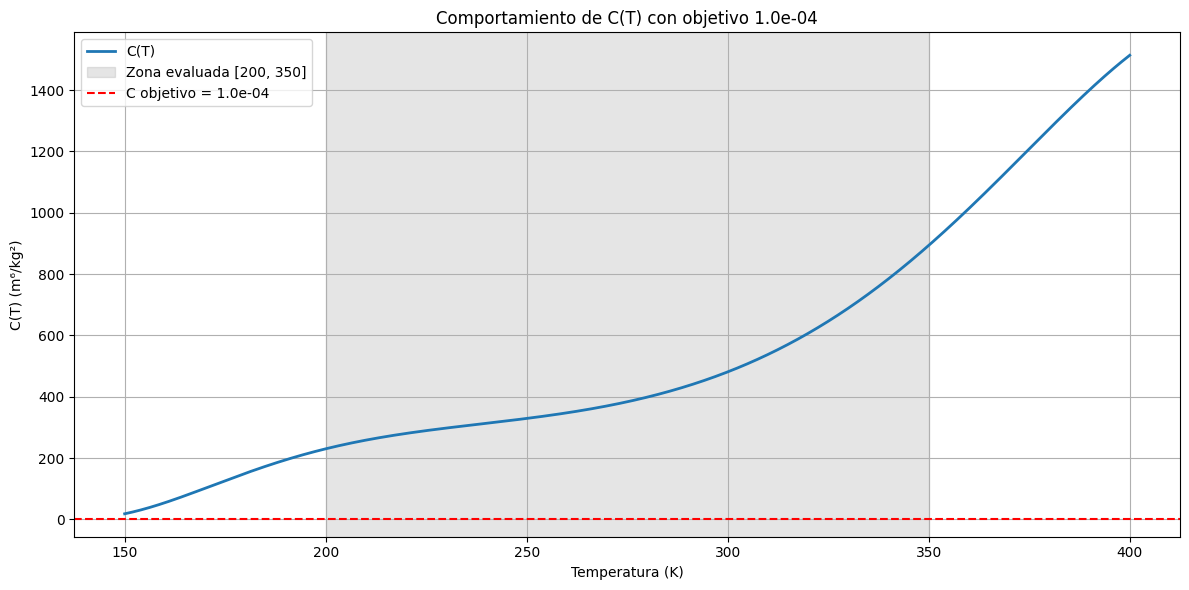

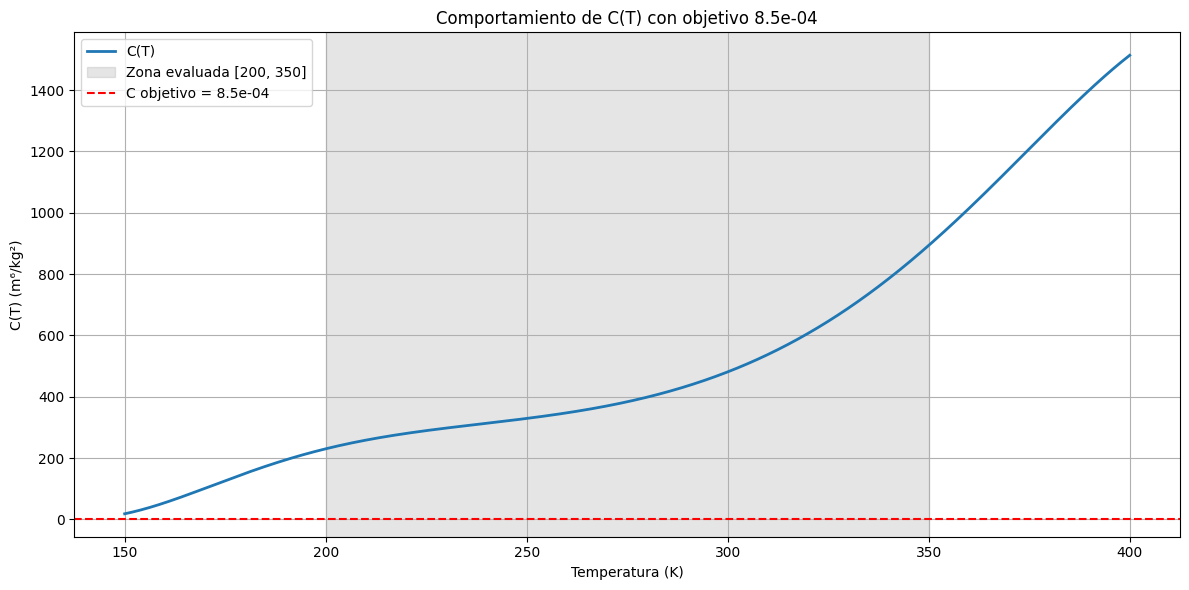

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import symbols, lambdify

# ------------------ DATOS ------------------

# Datos experimentales (temperatura, volumen específico)
data_points = [(200, 2.8), (250, 3.4), (300, 4.1), (350, 5.3)]
derivatives_info = {300: 0.019}

# Constantes del problema
P = 1e6  # Presión en Pa (1 MPa)
R = 461.5  # Constante del gas específico en J/(kg·K)

# ------------------ HERMITE ------------------

def diferencias_divididas_hermite(data_points, derivatives_info):
    z = []
    Q = []

    for T_i, v_i in data_points:
        z.append(T_i)
        Q.append([v_i])
        if T_i in derivatives_info:
            z.append(T_i)
            Q.append([v_i])
            Q[-1].append(derivatives_info[T_i])
            Q[-2].append(derivatives_info[T_i])

    m = len(z)
    for row in Q:
        while len(row) < m:
            row.append(0)

    for j in range(1, m):
        for i in range(m - j):
            if j == 1 and z[i] == z[i + 1]:
                Q[i][j] = Q[i + 1][1]
            else:
                Q[i][j] = (Q[i + 1][j - 1] - Q[i][j - 1]) / (z[i + j] - z[i])

    return z, np.array(Q)

z, tabla_coef_hermite = diferencias_divididas_hermite(data_points, derivatives_info)

# Construir polinomio de Hermite
T = symbols('T')
hermite_expr = sum(
    tabla_coef_hermite[0, i] * np.prod([(T - z[k]) for k in range(i)])
    for i in range(len(z))
)
hermite_func = lambdify(T, hermite_expr, 'numpy')

# ------------------ FUNCIONES ------------------

# Coeficiente B(T)
B = lambda T_val: -0.199 + 0.20 * np.exp(-1131 / T_val**2)

# Función C(T)
def C_T(T_val):
    v_val = hermite_func(T_val)
    Z = P * v_val / (R * T_val)
    return v_val**2 * (Z - 1 - B(T_val)/v_val)

# Método de la secante
def secante(func, x0, x1, tol, max_iter=1000):
    iteraciones = 0
    while abs(x1 - x0) > tol and iteraciones < max_iter:
        f_x0 = func(x0)
        f_x1 = func(x1)
        if f_x1 - f_x0 == 0:
            break
        x_temp = x1 - f_x1 * (x1 - x0) / (f_x1 - f_x0)
        x0, x1 = x1, x_temp
        iteraciones += 1
    return x1, iteraciones

# ------------------ NUEVOS VALORES OBJETIVO ------------------

C_targets = [1e-4, 8.5e-4]
tolerancia = 0.001
resultados_secante = []

for C_target in C_targets:
    T_encontrada, n_iter = secante(lambda T_val: C_T(T_val) - C_target, 200, 350, tolerancia)
    resultados_secante.append((C_target, tolerancia, n_iter, T_encontrada))

# Crear DataFrame
df_resultados = pd.DataFrame(resultados_secante, columns=[
    "C objetivo (m^6/kg^2)", "Tolerancia", "Iteraciones", "Temperatura encontrada (K)"
])

# Redondear resultados
df_resultados["Temperatura encontrada (K)"] = df_resultados["Temperatura encontrada (K)"].round(6)

# Formatear columnas
df_resultados["C objetivo (m^6/kg^2)"] = df_resultados["C objetivo (m^6/kg^2)"].apply(
    lambda x: f"{x:.1e}".replace('e-0', '·10^⁻').replace('e-', '·10^⁻')
)
df_resultados["Tolerancia"] = df_resultados["Tolerancia"].apply(
    lambda x: f"{x:.3f}".rstrip('0').rstrip('.') if x >= 1e-3 else f"{x:.1e}".replace('e-0', '·10^⁻').replace('e-', '·10^⁻')
)

# Mostrar tabla
print(df_resultados.to_string(index=False))

# ------------------ DOS GRÁFICAS, UNA POR OBJETIVO ------------------

T_vals_plot = np.linspace(150, 400, 1000)
C_vals = [C_T(T) for T in T_vals_plot]

for C_target in [1e-4, 8.5e-4]:
    plt.figure(figsize=(12, 6))
    plt.plot(T_vals_plot, C_vals, label='C(T)', linewidth=2)
    
    # Sombrear zona [200, 350]
    plt.axvspan(200, 350, color='gray', alpha=0.2, label='Zona evaluada [200, 350]')

    # Línea horizontal del objetivo
    plt.axhline(C_target, linestyle='--', color='red', label=f'C objetivo = {C_target:.1e}')

    # Marcar intersección (si la hay)
    for i in range(len(T_vals_plot) - 1):
        if (C_vals[i] - C_target) * (C_vals[i + 1] - C_target) < 0:
            T0, T1 = T_vals_plot[i], T_vals_plot[i + 1]
            T_cross, _ = secante(lambda T: C_T(T) - C_target, T0, T1, 1e-10)
            plt.axvline(T_cross, linestyle=':', color='green', label=f'Cruce ≈ {T_cross:.2f} K')

    plt.xlabel('Temperatura (K)')
    plt.ylabel('C(T) (m⁶/kg²)')
    plt.title(f'Comportamiento de C(T) con objetivo {C_target:.1e}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
